In [1]:
import os
from myfunctions_tf import load_mrui_txt_data
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

2025-09-01 08:36:18.288084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-01 08:36:18.288124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-01 08:36:18.290080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-01 08:36:18.461685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/stud/casperc/.local/lib/python3.10/site-pack

In [24]:
from scipy.interpolate import interp1d
def resample_input_data(metadata, FID, wanted_ppm):
    # Extract sampling interval and calculate ppm range
    sampling_interval = float(metadata["SamplingInterval"]) * 1E-3
    sampling_frequency = 1 / sampling_interval
    ppm_band_width = sampling_frequency * 1E6 / float(metadata["TransmitterFrequency"])
    
    # Calculate the original ppm range
    data_ppm = np.linspace(4.7 - ppm_band_width / 2, 4.7 + ppm_band_width / 2, int(metadata["PointsInDataset"]))
    
    # Check if the data's ppm range is sufficient
    if data_ppm.min()>wanted_ppm.min() and data_ppm.max()<wanted_ppm.max():
        raise ValueError(f"Data's ppm range is contained in the desired ppm range. Data ppm: {data_ppm[0]} to {data_ppm[-1]}, Desired ppm: {wanted_ppm[0]} to {wanted_ppm[-1]} and cannot be resampled.")
    
    # Extract the desired ppm range
    ppm_where = np.where((data_ppm >= wanted_ppm.min()) & (data_ppm <= wanted_ppm.max()))[0]
    FID_extracted = FID[ppm_where]
    data_ppm_extracted = data_ppm[ppm_where]
    
    # Interpolate to match the desired ppm length
    if len(data_ppm_extracted) != len(wanted_ppm):
        target_ppm = np.linspace(wanted_ppm.min(), wanted_ppm.max(), len(wanted_ppm))
        interpolator = interp1d(data_ppm_extracted, FID_extracted, kind="linear", fill_value="extrapolate")
        FID_interpolated = interpolator(target_ppm)
    else:
        FID_interpolated = FID_extracted
    
    return FID_interpolated

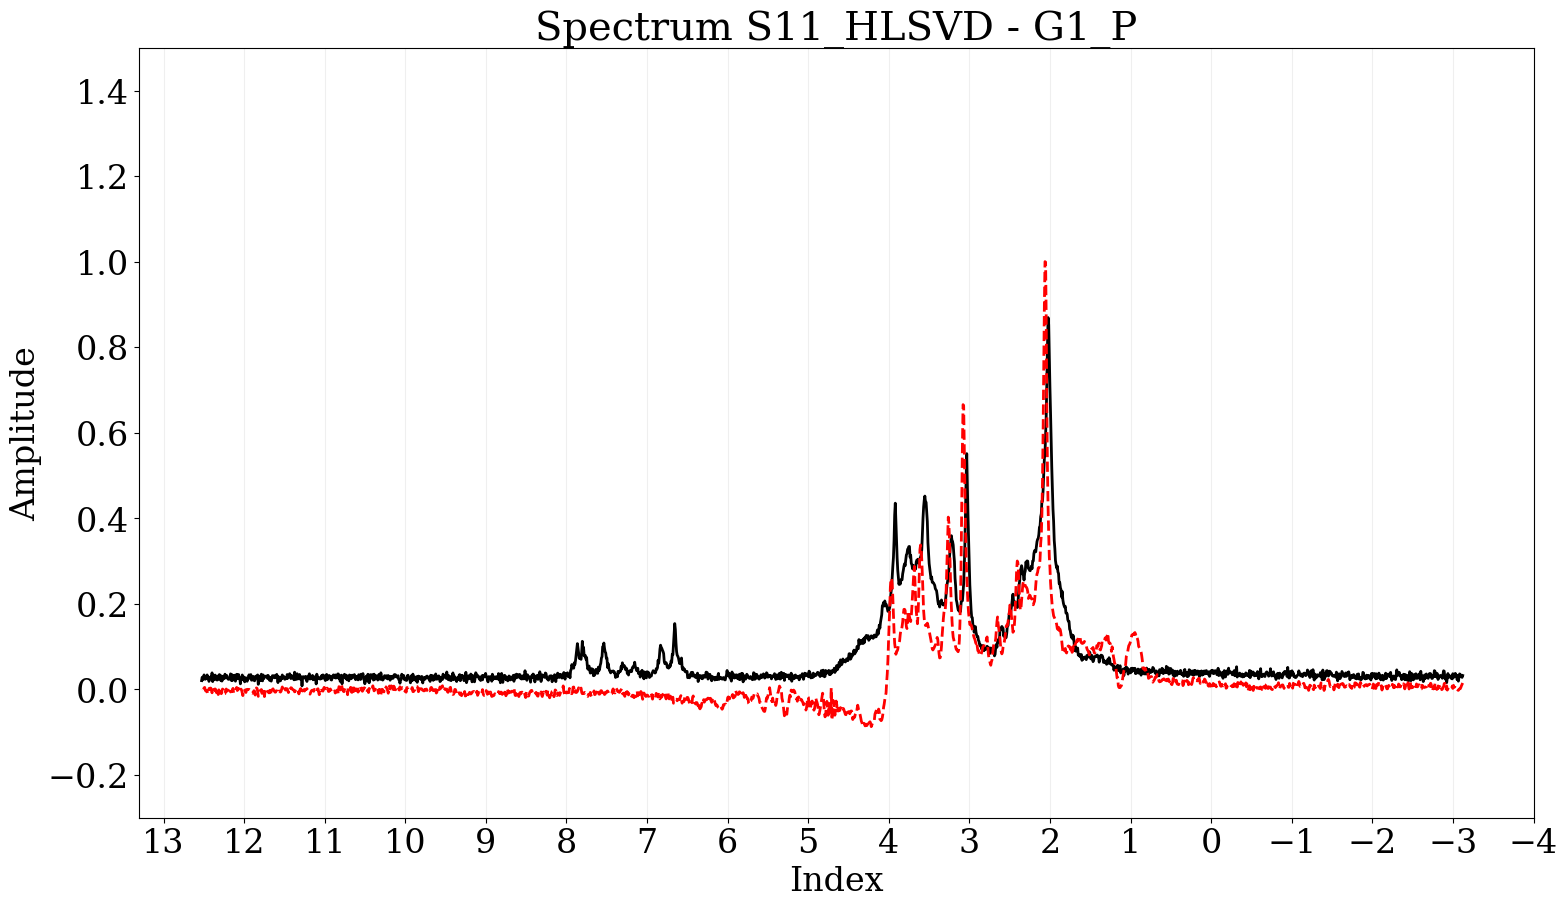

MSE for In Vivo Spectra vs mean:
{'G1_P_S0_HLSVD1': 0.014489463011354863, 'G1_P_S03_HLSVD': 0.013378250125573202, 'G1_P_S04_HLSVD': 0.013550614751713643, 'G1_P_S05_HLSVD': 0.01403027397015095, 'G1_P_S07_HLSVD': 0.012022879236258098, 'G1_P_S09_HLSVD': 0.008430329417202702, 'G1_P_S11_HLSVD': 0.013598179999809092}


In [95]:
from IPython.display import clear_output, display
from scipy.spatial.distance import euclidean
import sys
synth_data_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2"
in_vivo_data_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/mrui_files"
mean_spectrum_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/mean_spectrum.npz"
CALCULATE_MEAN = True

if CALCULATE_MEAN:
    synth_data = os.listdir(synth_data_path)
    synth_data = random.sample(synth_data, 50)
    synth_data = [os.path.join(synth_data_path, f) for f in synth_data]
    data_array = np.empty((len(synth_data), 2048), dtype=np.complex128)
    for i, file in enumerate(tqdm.tqdm(synth_data, desc="Loading spectra")):
        with np.load(file) as data:
            data_array[i] = data['augmented']-data['Tau']*3/4
    mean_spectrum = np.mean(data_array, axis=0)
    #np.savez(mean_spectrum_path, mean_spectrum=mean_spectrum)
else:
    with np.load(mean_spectrum_path) as data:
        mean_spectrum = data['mean_spectrum']

vendors = ["G1_P"]#os.listdir(in_vivo_data_path)
mse = {}
fig, ax = plt.subplots()
for vendor in vendors:
    vendor_path = os.path.join(in_vivo_data_path, vendor)
    spectra = sorted([f for f in os.listdir(vendor_path) if "HLSVD" in f])
    for i, in_vivo_data in enumerate(spectra):
        FID, spec, metadata = load_mrui_txt_data(os.path.join(vendor_path, in_vivo_data))
        ppm = np.linspace(-3.121, 12.528, 2048)

        if len(FID) == 4096:
            sampling_interval = float(metadata["SamplingInterval"]) * 1E-3
            sampling_frequency = 1 / sampling_interval
            ppm_band_width = sampling_frequency * 1E6 / float(metadata["TransmitterFrequency"])
            original_ppm = np.linspace(4.7 - ppm_band_width / 2, 4.7 + ppm_band_width / 2, int(metadata["PointsInDataset"]))
            spec_resampled = resample_input_data(metadata, spec, ppm)
        elif len(FID) == 2048:
            original_ppm = ppm.copy()
            spec_resampled = spec.copy()

        ppm_where = np.where((ppm > 0) & (ppm < 4.2))
        norm_val = np.max(spec_resampled[ppm_where])
        spec_resampled = spec_resampled / norm_val

        original_ppm_where = np.where((original_ppm > 0) & (original_ppm < 4.2))
        orgiginal_norm_val = np.max(spec[original_ppm_where])
        spec = spec / orgiginal_norm_val
        
        # Compute MSE in the 0–4.2 ppm region
        region = (ppm > 0) & (ppm < 4.2)
        a = mean_spectrum.real[region]
        b = spec_resampled.real[region]
        mse[f"{vendor}_{metadata['Filename'].replace('.txt', '')}"] = (euclidean(a, b) ** 2) / a.size  # mean squared error
        ax.cla()
        ax.plot(ppm, mean_spectrum.real, label='Mean Synthetic Spectrum', linewidth=2, color='black')
        ax.plot(ppm, spec_resampled, label='In Vivo Spectrum', linewidth=2, linestyle='--', color='red')
        ax.set_title(f"Spectrum {metadata['Filename'].replace('.txt', '')} - {vendor}")
        ax.set_xlabel("Index")
        ax.invert_xaxis()
        ax.set_ylim(-0.3, 1.5)
        ax.set_ylabel("Amplitude")
        tick_step = 1
        ppm_min = np.floor(ppm.min())
        ppm_max = np.ceil(ppm.max())
        ax.set_xticks(np.arange(ppm_min, ppm_max + tick_step, tick_step))
        ax.tick_params(axis='x', labelrotation=0)
        ax.grid(alpha=0.2, which='both', axis='x')
        clear_output(wait=True)
        display(fig)
        _ = input("Enter for next (Ctrl+C to stop)...")

plt.close(fig)
print("MSE for In Vivo Spectra vs mean:")
print(mse)



{'Filename': 'S03.txt', 'PointsInDataset': '4096', 'DatasetsInFile': '1', 'SamplingInterval': '2E-1', 'ZeroOrderPhase': '0E0', 'BeginTime': '0E0', 'TransmitterFrequency': '1.2777E8', 'MagneticField': '3.001E0', 'TypeOfNucleus': '-1E0'}


/home/stud/casperc/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stud/casperc/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


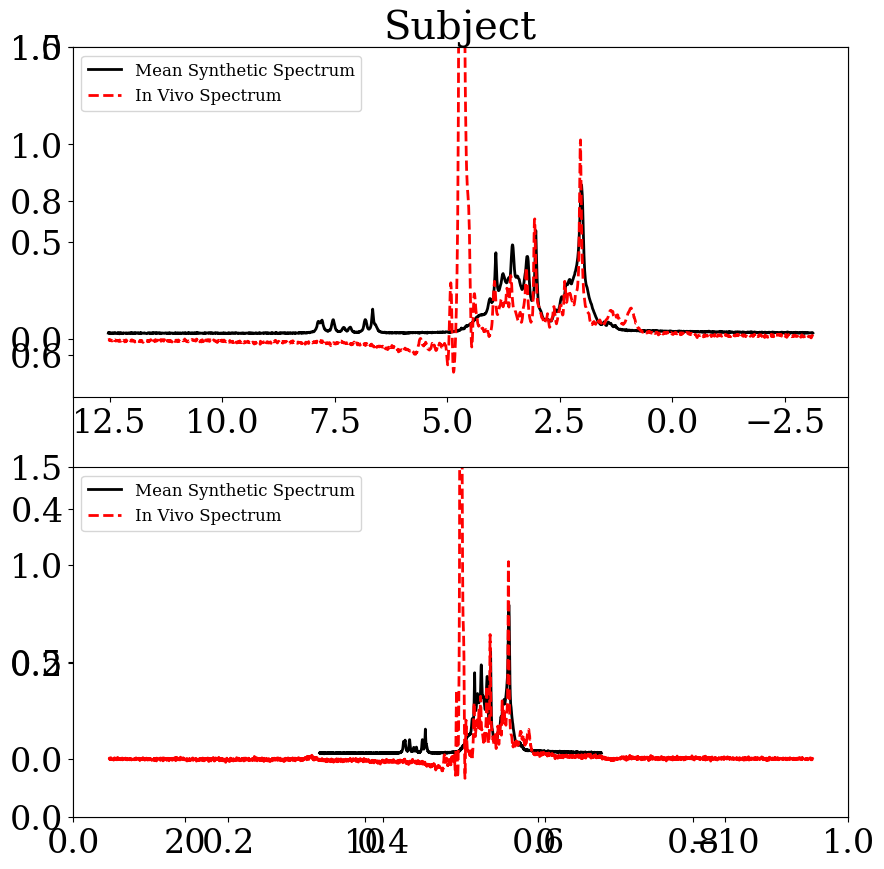

In [48]:
in_vivo_data_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/in_vivo_data/mrui_files/G1_P/S03.txt"
FID, spec, metadata = load_mrui_txt_data(in_vivo_data_path)
print(metadata)
ppm = np.linspace(-3.121, 12.528, 2048)

if len(FID) == 4096:
    sampling_interval = float(metadata["SamplingInterval"]) * 1E-3
    sampling_frequency = 1 / sampling_interval
    ppm_band_width = sampling_frequency * 1E6 / float(metadata["TransmitterFrequency"])
    original_ppm = np.linspace(4.7 - ppm_band_width / 2, 4.7 + ppm_band_width / 2, int(metadata["PointsInDataset"]))
    spec_resampled = resample_input_data(metadata, spec, ppm)
elif len(FID) == 2048:
    original_ppm = ppm.copy()
    spec_resampled = spec.copy()

ppm_where = np.where((ppm > 0) & (ppm < 4.2))
norm_val = np.max(spec_resampled[ppm_where])
spec_resampled = spec_resampled / norm_val

original_ppm_where = np.where((original_ppm > 0) & (original_ppm < 4.2))
orgiginal_norm_val = np.max(spec[original_ppm_where])
spec = spec / orgiginal_norm_val


plt.figure(figsize=(10,10))
plt.title(f"Subject")
plt.subplot(2,1,1)
plt.plot(ppm, mean_spectrum.real, label='Mean Synthetic Spectrum', linewidth=2, color='black')
plt.plot(ppm, spec_resampled, label='In Vivo Spectrum', linewidth=2, linestyle='--', color='red')
plt.ylim(-0.3, 1.5)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=12)



plt.subplot(2,1,2)
plt.plot(ppm, mean_spectrum.real, label='Mean Synthetic Spectrum', linewidth=2, color='black')
plt.plot(original_ppm, spec.real, label='In Vivo Spectrum', linewidth=2, linestyle='--', color='red')
plt.ylim(-0.3, 1.5)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [1]:
data_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/generated_data/train_2/TE30_lw07_1101_data.npz"
ppm = np.linspace(-3.121, 12.528, 2048)
data = np.load(data_path)
for key in data.keys():
    print(key)
metabolite_concentrations = {
                "Ala": (0.1, 1.5), "Asp": (1.0, 2.0), "Cr": (4.0, 7.0), "GABA": (2.0, 3.0), "Glc": (1.0, 2.0),
                "Gln": (2.0, 5.0), "Glu": (4.0, 6.0), "GPC": (0.5, 2.0), "GSH": (1.5, 3.0), "Lac": (0.2, 1.0),
                "mI": (4.0, 7.0), "NAA": (7.5, 10), "NAAG": (0.5, 2.5), "PCho": (0.5, 2.0), "PCr": (1.0, 3), "Tau": (2.0, 5.0), "Gly":(1.0, 2.0) #Check the values
            }
keys = metabolite_concentrations.keys()#["mI", "Glu", "Gln", "NAA", "GABA", "Cr", "PCr","Gly"]

for key in keys:
    if key in data.keys()[:1]:
        plt.figure()
        plt.plot(ppm, data['augmented']-data['baseline'], label='augmented-baseline', color='green')
        
        plt.plot(ppm, data[key].real, label=key)
        
        plt.xlabel("PPM")
        plt.ylabel("Amplitude")
        plt.title("Metabolite Spectra")
        plt.legend()
        plt.gca().invert_xaxis()
        plt.show()



NameError: name 'np' is not defined

In [46]:
import matplotlib.pyplot as plt
def add_lines(ppm):
    for pos in ppm:
        plt.axvline(x=pos, color='gray', linestyle='--', linewidth=2)

In [189]:
from scipy.interpolate import interp1d
import scipy
base_path = "/home/stud/casperc/bhome/Project3_DL_sigpros/DL_basis_sets" 
save_location = "/home/stud/casperc/bhome/Project3_DL_sigpros/DL_basis_sets_corrected"
TEs = [20, 30, 40]
lws = [3, 5, 7, 10]
ppm = np.linspace(-3.121, 12.528,  2048)
DO_PLOTTING = False
# Define metabolite concentration ranges
metabolite_concentrations = {
    "Ala": (0.1, 1.5), "Cr": (4.0, 7.0), "GABA": (2.0, 3.0), "Glc": (1.0, 2.0),
    "Gln": (2.0, 5.0), "Glu": (4.0, 6.0), "GPC": (0.5, 2.0), "GSH": (1.5, 3.0), "Lac": (0.2, 1.0),
    "mI": (4.0, 7.0), "NAA": (7.5, 10), "NAAG": (0.5, 2.5), "PCho": (0.5, 2.0), "PCr": (1.0, 3), "Tau": (0.5, 1.25), "Gly":(1.0, 2.0) #Check the values , "Asp": (1.0, 2.0)
}
metabolites_to_correct_satellites = [
    "Cr", "Gln", "GSH", "NAA", "PCr"
]

for TE in TEs:
    for lw in lws:
        save_path = os.path.join(save_location, f"TE{TE}_lw{lw:02d}")
        os.makedirs(save_path, exist_ok=True)
        for metabolite in metabolite_concentrations:
            metabolite_path = os.path.join(base_path, f"TE{TE}_lw{lw:02d}/{metabolite}.txt")
            FID, spec, metadata = load_mrui_txt_data(metabolite_path)
            spec = scipy.fft.fftshift(spec)
            spec_new = spec.copy()
            if metabolite in metabolites_to_correct_satellites:
                ppm_where = np.where((ppm > 5.5))
                spec_new[ppm_where] = interp1d([ppm[ppm_where][0], ppm[ppm_where][-1]], [spec_new[ppm_where][0].real, spec_new[ppm_where][-1].real], kind='linear', fill_value='extrapolate')(ppm[ppm_where])
            spec_new -= spec.real[2000:].min()
            FID_new = scipy.fft.ifft(scipy.fft.fftshift(spec_new))
            # Save new basis set to NPZ
            out_file = os.path.join(save_path, f"{metabolite}.npz")
            np.savez(out_file, FID=FID_new, spec=spec_new, metadata=metadata, allow_pickle=True)
            if DO_PLOTTING:
                plt.figure()
                plt.subplot(1,2,1)
                plt.title(f"{metabolite} TE{TE} lw{lw}")
                plt.plot(ppm, spec.real, label='Original')
                plt.plot(ppm, spec_new.real, label='Corrected')
                plt.legend(fontsize=12)
                plt.subplot(1,2,2)
                plt.plot(ppm, FID.real, label='Original')
                plt.plot(ppm, FID_new.real, label='Corrected')
                plt.legend(fontsize=12)

In [ ]:
import numpy as np

load_path = "bhome/Project3_DL_sigpros/DL_basis_sets_corrected"
ppm = np.linspace(-3.121, 12.528, 2048)
t = np.linspace(0, 0.5, 2048)
TEs = [20, 30, 40]
lws = [3, 5, 7, 10]
for TE in TEs:
    for lw in lws:
        total_FID = 0
        total_spec = 0
        plt.figure()
        for metabolite in metabolite_concentrations:
            load_file = os.path.join(load_path, f"TE{TE}_lw{lw:02d}/{metabolite}.npz")
            with np.load(load_file, allow_pickle=True) as data:
                metadata = data['metadata'].item()
                FID = data['FID']
                spec = data['spec']
                total_FID += FID
                total_spec += spec
                plt.subplot(1,3,1)
                plt.plot(ppm, spec.real, label=metabolite)
        plt.subplot(1,3,2)
        plt.plot(ppm, total_spec.real, label='Total')
        plt.title(f"Total TE{TE} lw{lw}")
        plt.xlabel("PPM")
        plt.ylabel("Amplitude")
        plt.gca().invert_xaxis()
        plt.legend()
        plt.subplot(1,3,3)
        plt.plot(ppm, total_FID.real, label='Total')
        plt.title(f"Total FID TE{TE} lw{lw}")
        plt.xlabel("PPM")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()